In [ ]:
!sudo apt-get install cython libglpk-dev python python-dev python-pip python-scipy
%pip install pypoman
%pip install pandas

In [9]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import math as m
import scipy.optimize as opt
import pandas as pd
import pypoman as pyp

Данные выборки:

In [31]:
data = pd.read_csv('Channel_1_700nm_0.2.csv', sep=';', encoding='cp1251')
eps = 10e-4
data = data['мВ']
interval_data = []
for i in range (0, len(data)):
    interval_data.append([data[i] - eps, data[i] + eps])

Визуализация данных выборки

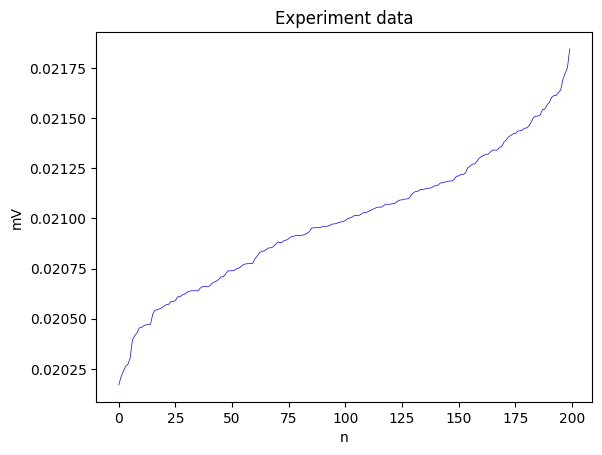

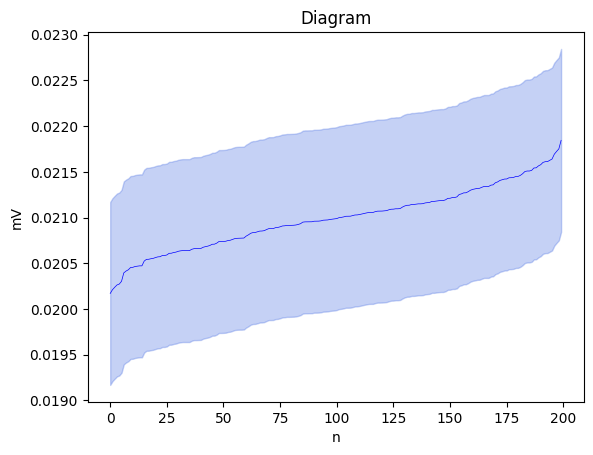

In [32]:
def plot_data(data):
    plt.figure()
    data.plot(color = 'blue', linewidth = 0.5)
    plt.title('Experiment data')
    plt.xlabel('n')
    plt.ylabel('mV')
    plt.savefig('data.png')

def diagram(data, epsilon, beta):
    plt.figure()
    plt.fill_between(data.index, data - epsilon, data + epsilon, color = 'royalblue', alpha = 0.3)
    plt.plot(data.index, data, color = 'blue', linewidth = 0.5)
    if beta is not None: 
        plt.plot([0, 199],[beta, beta], color = "maroon", linestyle = "--", linewidth = 0.5)
    plt.title('Diagram')
    plt.xlabel('n')
    plt.ylabel('mV')
    plt.savefig(f'diagram_beta_{beta}.png')

plot_data(data)
diagram(data, eps, None)

Варьирование неопределнности измерений

Без сужения интервалов

In [33]:
def minimization(A, y, eps, lim):
    [m, n] = A.shape

    c = np.concatenate((np.zeros((n, 1)), np.ones((m, 1))), axis=0)
    c = np.ravel(c)

    diag = np.diag(np.full(m, -eps))

    M_1 = np.concatenate((-A, diag), axis=1)
    M_2 = np.concatenate((A, diag), axis=1)
    M = np.concatenate((M_1, M_2), axis=0)

    v = np.concatenate((-y, y), axis=0)

    l_b = np.concatenate((np.full(n, None), np.full(m, lim)), axis=0)
    print(l_b)
    u_b = np.full(n + m, None)

    bounds = [(l_b[i], u_b[i]) for i in range(len(l_b))]

    result = opt.linprog(c=c, A_ub=M, b_ub=v, bounds=bounds)
    y = result.x

    coefs = y[0:n]
    w = y[n:n+m]

    return [coefs, w]


def parser(lim):
    data = pd.read_csv('Channel_1_700nm_0.2.csv', sep=';', encoding='cp1251')

    data_mv = np.ravel(data.drop('мА', axis=1).to_numpy())
    
    data_n = np.arange(1, len(data_mv) + 1, 1)

    data_eps = 1e-4

    data_X = np.stack((np.ones(len(data_mv)), data_n))
    data_X = np.transpose(data_X)
    [data_tau, data_w] = minimization(data_X, data_mv, data_eps, lim)


    with open(f'Chi{lim}.txt', 'w') as f:
        print(f'{data_tau[0]} {data_tau[1]}', file=f)
        for temp in data_w:
            print(temp, file=f)


def load_processed(filename):
    A = 0
    B = 0
    w = []
    with open(filename) as f:
        A, B = [float(t) for t in f.readline().split()]
        for line in f.readlines():
            w.append(float(line))
    return A, B, w


[None None 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.02032890551181103, 6.503937007873972e-06]
202.83141732283462


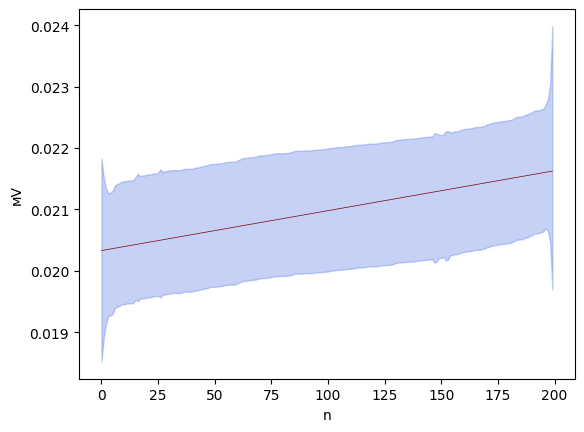

In [34]:
parser(1)
A1, B1, w1 = load_processed('Chi1.txt')
print([A1, B1])
print(np.sum(w1))
plt.fill_between(data.index, np.array(data) + np.array(w1) * eps, np.array(data) - np.array(w1) * eps, color = 'royalblue', alpha = 0.3)
# plt.fill_between(data.index, np.array(data) + eps, np.array(data) - eps, color = 'royalblue', alpha = 0.3)
plt.plot(np.arange(0, 200), A1 + B1 * (np.arange(0, 200)), label='lsm', color='maroon', linewidth = 0.5)
plt.xlabel('n')
plt.ylabel('мV')
plt.savefig('diagram_and_regress_1.png')
plt.show()
plt.close()

С сужением интервалов

[None None 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[2.8713924050633235, 2.5149367088607777, 2.2984810126582684, 2.102025316455709, 2.055569620253196, 1.8091139240506218, 0.9426582278481213, 0.7962025316456123, 0.7097468354430592, 0.5132911392405348, 0.5468354430379976, 0.5103797468354598, 0.5239240506329373, 0.5474683544303901, 0.601012658227873, 0.13455696202532147, 0.0018987341771775634, 0.04164556962026056, 0.03518987341775276, 0.04873417721523027, 0.012278481012657771, 0.0041772151898600285, 0.029367088607602787, 0.04708860759490563, 0.006455696202577188, -0.0, 0.12645569620248903, 0.08291139240505091, 0.10936708860757871,

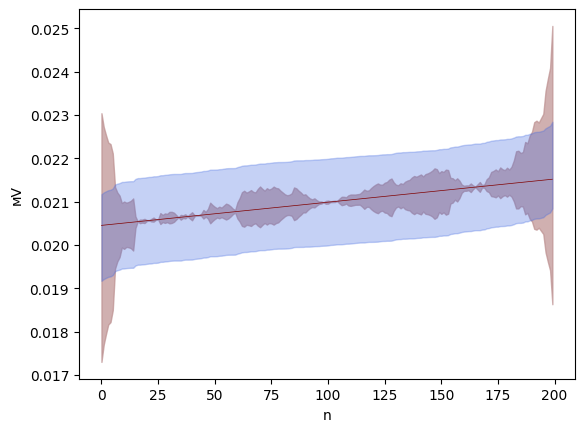

In [47]:
parser(0)
A0, B0, w0 = load_processed('Chi0.txt')
print(w0)
print([A0, B0])
print(np.sum(w0))
plt.fill_between(data.index, np.array(data) + np.array(w0) * eps, np.array(data) - np.array(w0) * eps, color = 'rosybrown', alpha = 0.7)
plt.fill_between(data.index, np.array(data) + eps, np.array(data) - eps, color = 'royalblue', alpha = 0.3)
plt.plot(np.arange(0, 200), A0 + B0 * (np.arange(0, 200)), label='lsm', color='maroon', linewidth = 0.5)
plt.xlabel('n')
plt.ylabel('мV')
plt.savefig('diagram_and_regress_0.png')
plt.show()
plt.close()

Векторы w1 и w0

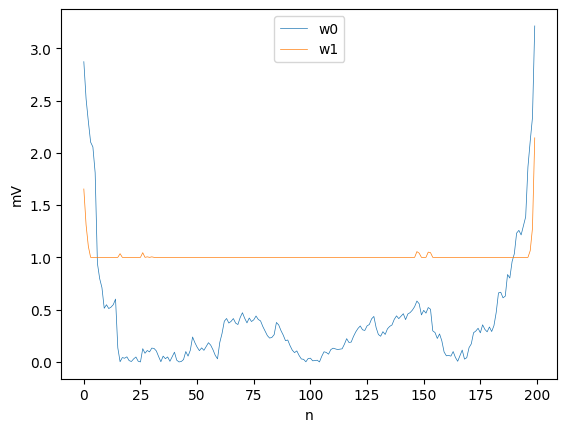

In [36]:
plt.figure()
plt.plot(data.index, w0, linewidth = 0.5, label = 'w0')
plt.plot(data.index, w1, linewidth = 0.5, label = 'w1')
plt.legend()
plt.xlabel('n')
plt.ylabel('mV')
plt.savefig('w0_w1.png')
plt.show()
plt.close()

Анализ регрессионных остатков

Модель без сужения интервалов

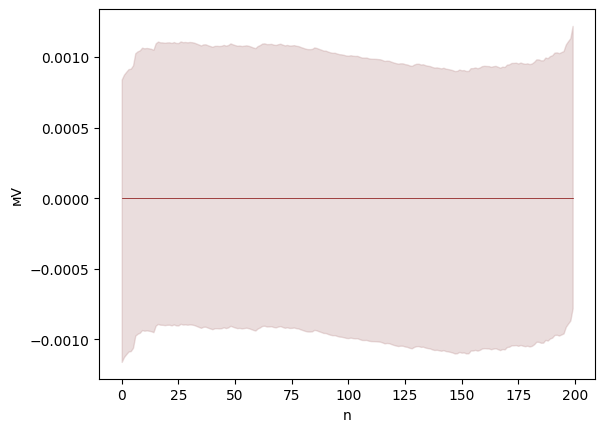

In [37]:
plt.figure()
plt.fill_between(data.index, np.array(data) + eps - (A1 + B1 * (np.arange(0, 200))), np.array(data) - eps - (A1 + B1 * (np.arange(0, 200))), color = 'rosybrown', alpha = 0.3)
plt.plot([0, 199], [0, 0], label='lsm', color='maroon', linewidth = 0.5)
plt.xlabel('n')
plt.ylabel('мV')
plt.savefig('analysis_of_regression_residuals_1.png')
plt.show()
plt.close()

Модель с сужениями интервалов

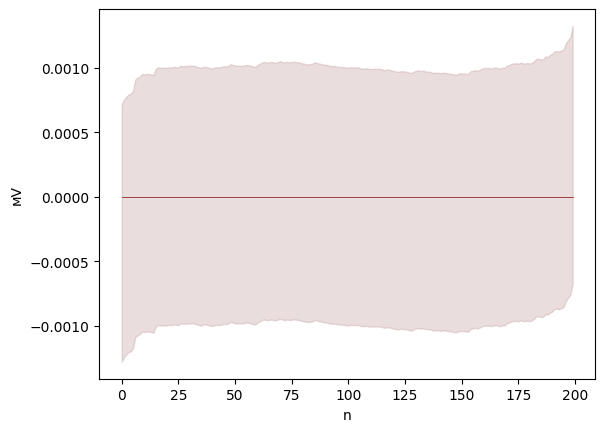

In [38]:
plt.figure()
plt.fill_between(data.index, np.array(data) + eps - (A0 + B0 * (np.arange(0, 200))), np.array(data) - eps - (A0 + B0 * (np.arange(0, 200))), color = 'rosybrown', alpha = 0.3)
plt.plot([0, 199], [0, 0], label='lsm', color='maroon', linewidth = 0.5)
plt.xlabel('n')
plt.ylabel('мV')
plt.savefig('analysis_of_regression_residuals_0.png')
plt.show()
plt.close()

Частоты элементарных подинтервалов при вычислении моды модели

In [39]:
def subinterval_frequencies_and_mode(A, B, eps, data):
    y = []
    for i in range (0, len(data)):
        y.append(data[i] + eps - (A + B * i))
        y.append(data[i] - eps - (A + B * i))
    
    y = list(set(y))
    y.sort()

    z = []

    for i in range (0, len(y) - 1):
        z.append([y[i], y[i+1]])
    
    max_mu = 0
    coefs = []
    mus = []

    for i in range (0, len(z)):
        mu = 0 
        for j in range(0, len(data)):
            if data[j] - eps - (A + B * j) <= z[i][0] and data[j] + eps - (A + B * j) >= z[i][1]:
                mu += 1
        mus.append(mu)

        if mu > max_mu: 
            max_mu = mu 
            coefs = []
            coefs.append(i)
        
        if mu == max_mu:
            coefs.append(i)
  
    mode = []
    
    for i in range (0, len(z)):
        if i in coefs:
            mode.append(z[i])
    
    for k in range (0, len(mode)-1):
      if mode[k][1] == mode[k+1][0]:
        mode[k] = [mode[k][0], mode[k+1][1]]

    return mode, max_mu, z, mus 

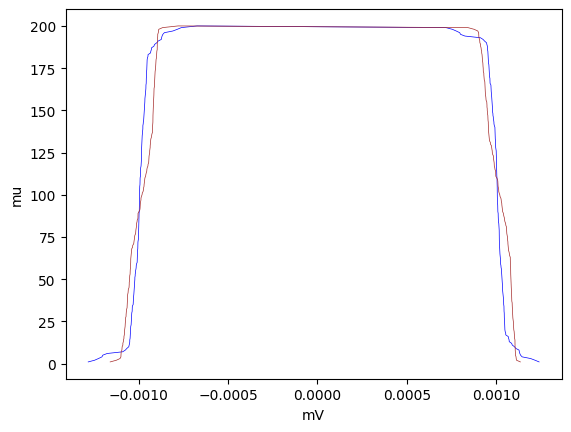

mode_0 = [[-0.0006733164556962067, 0.0007182151898734168]] mu_max_0 = 200
mode_1 = [[-0.0007791889763779508, 0.0008410944881889725]], mu_max_1 = 200


In [40]:
result_0 = subinterval_frequencies_and_mode(A0, B0, eps, data)
result_1 = subinterval_frequencies_and_mode(A1, B1, eps, data)
mode_0 = result_0[0]
mode_1 = result_1[0]
max_mu_0 = result_0[1]
max_mu_1 = result_1[1]
z_0 = np.array(result_0[2])
z_1 = np.array(result_1[2])
mu_0 = result_0[3]
mu_1 = result_1[3]
plt.figure()
plt.plot(z_0[:, 0], mu_0, linewidth = 0.5, color = 'blue')
plt.plot(z_1[:, 0], mu_1, linewidth = 0.5, color = 'brown')
plt.xlabel('mV')
plt.ylabel('mu')
plt.savefig('mu.png')
plt.show()
print(f'mode_0 = {mode_0} mu_max_0 = {max_mu_0}')
print(f'mode_1 = {mode_1}, mu_max_1 = {max_mu_1}')



Коэфициент Жакара

In [41]:
def Jakar_coeff(A, B, eps, data):
    min_inc, max_inc = [], []
    min_inc.append(data[0] - eps - A)
    min_inc.append(data[0] + eps - A)
    max_inc.append(data[0] - eps - A)
    max_inc.append(data[0] + eps - A)
    for i in range(0, len(data)):
        min_inc[0] = max(min_inc[0], data[i] - eps - (A + B * i))
        min_inc[1] = min(min_inc[1], data[i] + eps - (A + B * i))
        max_inc[0] = min(max_inc[0], data[i] - eps - (A + B * i))
        max_inc[1] = max(max_inc[1], data[i] + eps - (A + B * i))
    JK = (min_inc[1] - min_inc[0]) / (max_inc[1] - max_inc[0])
    return JK

In [42]:
J0 = Jakar_coeff(A0, B0, eps, data)
J1 = Jakar_coeff(A1, B1, eps, data)
print(f'Ji_0 = {J0}, Ji_1 = {J1}')

Ji_0 = 0.5334669455376608, Ji_1 = 0.6808724654560804


Информационное множество задачи

Найдем вершины многоугольника

In [43]:

A , b = [], []
for i in range (0, len(data)):
    A.append([1, i])
    A.append([-1, -i])
    b.append(data[i] + eps)
    b.append(-data[i] + eps)
A = np.array(A)
b = np.array(b)
vertices = np.array(pyp.compute_polytope_vertices(A,b))

beta_0_min = min(vertices[:,0])
beta_0_max = max(vertices[:,0])
beta_1_min = min(vertices[:,1])
beta_1_max = max(vertices[:,1])

print(f'beta_0 in [{beta_0_min},{beta_0_max}]')
print(f'beta_1 in [{beta_1_min},{beta_1_max}]')

beta_0 in [0.01929983870967741,0.02117]
beta_1 in [-1.6381909547739146e-06,1.7129032258064605e-05]


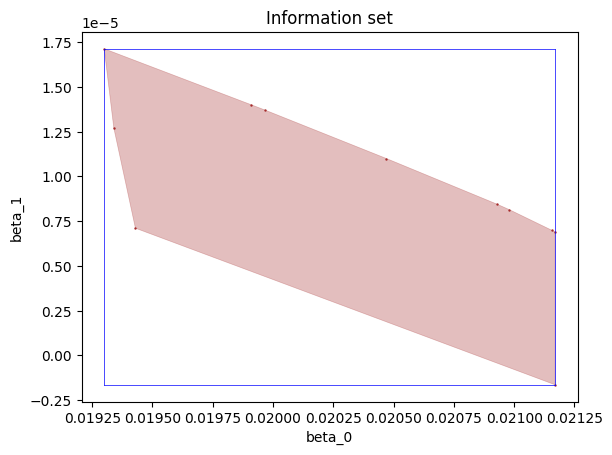

In [44]:
order = np.argsort(np.arctan2(vertices[:,1] - vertices[:,1].mean(), vertices[:,0] - vertices[:,0].mean()))

plt.figure()
plt.fill(vertices[:,0][order], vertices[:,1][order], edgecolor='red', color = 'brown', alpha = 0.3, linewidth = 0.5)
plt.scatter(vertices[:,0], vertices[:,1], color = 'brown', s = 0.5)
plt.plot([beta_0_min, beta_0_min], [beta_1_min, beta_1_max], linewidth = 0.5, color = 'blue')
plt.plot([beta_0_max, beta_0_max], [beta_1_min, beta_1_max], linewidth = 0.5, color = 'blue')
plt.plot([beta_0_min, beta_0_max], [beta_1_min, beta_1_min], linewidth = 0.5, color = 'blue')
plt.plot([beta_0_min, beta_0_max], [beta_1_max, beta_1_max], linewidth = 0.5, color = 'blue')
plt.xlabel('beta_0')
plt.ylabel('beta_1')
plt.title('Information set')
plt.savefig('inform_set.png')
plt.show()

Коридор совместных зависимостей

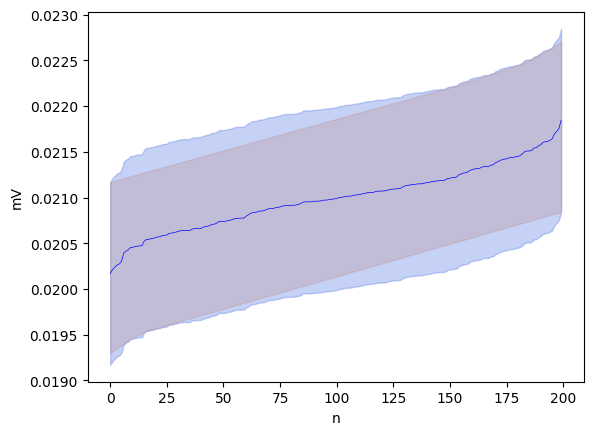

In [45]:
max_val, min_val = [], []
for i in range (0, len(data)):
    minimum = 100
    maximum = 0
    for v in vertices: 
        if v[0] + v[1] * i > maximum:
            maximum =  v[0] + v[1] * i
        if v[0] + v[1] * i < minimum:
            minimum = v[0] + v[1] * i
    min_val.append(minimum)
    max_val.append(maximum)

plt.figure()
plt.fill_between(data.index, np.array(data) + eps, np.array(data) - eps, color = 'royalblue', alpha = 0.3)
plt.plot(data.index, data, color = 'blue', linewidth = 0.5)
plt.fill_between(np.arange(0, 200), np.array(min_val), np.array(max_val), color='rosybrown', alpha = 0.3)
plt.xlabel('n')
plt.ylabel('mV')
plt.savefig('corridor_of_joint_dependencies.png')
plt.show()
plt.close()

Построение прогноза для n от -50 до 250

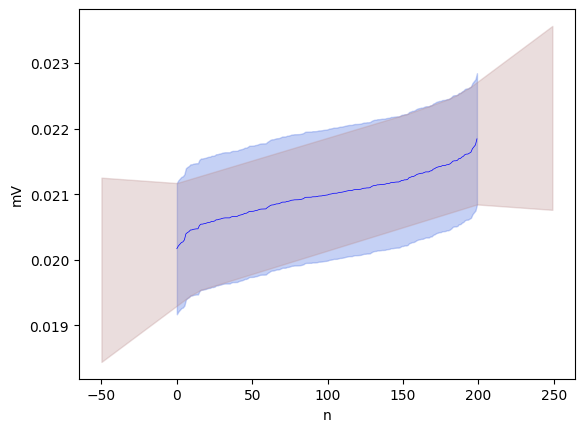

In [46]:
max_val_pr, min_val_pr = [], []
for i in range (-50, 250):
    minimum = 100
    maximum = 0
    for v in vertices: 
        if v[0] + v[1] * i > maximum:
            maximum =  v[0] + v[1] * i
        if v[0] + v[1] * i < minimum:
            minimum = v[0] + v[1] * i
    min_val_pr.append(minimum)
    max_val_pr.append(maximum)

plt.figure()
plt.fill_between(data.index, np.array(data) + eps, np.array(data) - eps, color = 'royalblue', alpha = 0.3)
plt.fill_between(np.arange(-50, 250), np.array(min_val_pr), np.array(max_val_pr), color='rosybrown', alpha = 0.3)
plt.plot(data.index, data, color = 'blue', linewidth = 0.5)
plt.xlabel('n')
plt.ylabel('mV')
plt.savefig('corridor_of_joint_dependencies_prediction.png')
plt.show()
plt.close()